## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import PyQt5
%matplotlib inline

### Camera Calibration with OpenCV
extract object points and image points

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

calibrate distortion coefficients and run undistortion image

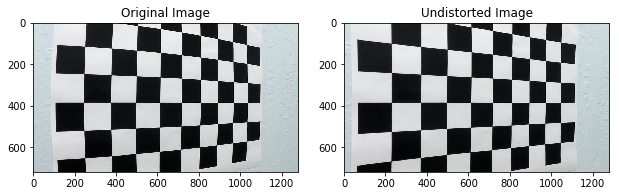

In [12]:
# Select an image
img = cv2.imread('./camera_cal/calibration5.jpg')

# Use cv2.calibrateCamera() and cv2.undistort()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Save mtx and dist

In [8]:
import pickle
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "./data/mtx_dist_pickle.p", "wb" ) )

### Perspective Transform

Load camera matrix and distortion coefficients

In [9]:
dist_pickle = pickle.load( open( "./data/mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [24]:
M

NameError: name 'M' is not defined

In [36]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):

    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
#     warped = np.copy(img)
#     M = 0

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                         [img_size[0]-offset, img_size[1]-offset], 
                         [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped, M

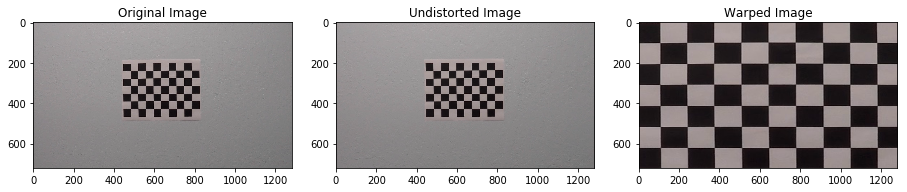

In [37]:
# Select an image
img = cv2.imread('./camera_cal/calibration6.jpg')
nx = 9
ny = 6

# Use cv2.calibrateCamera() and cv2.undistort()
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped, M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=12)
ax3.imshow(warped)
ax3.set_title('Warped Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## And so on and so forth...